<a href="https://colab.research.google.com/github/SaraGhR/hip-fracture-care-episodes/blob/main/hip_fracture_analyzing_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('star.csv')
df.shape

(516, 366)

vitual samples:

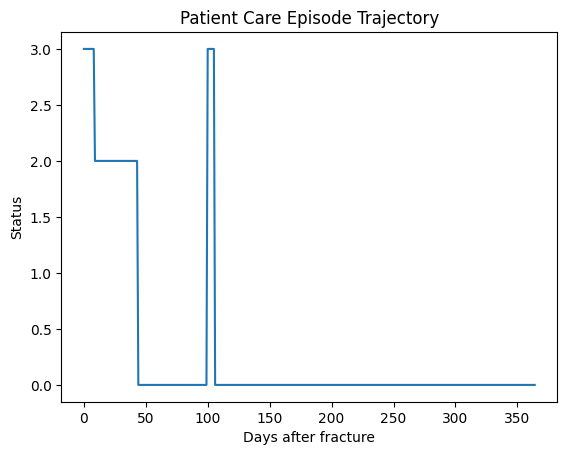

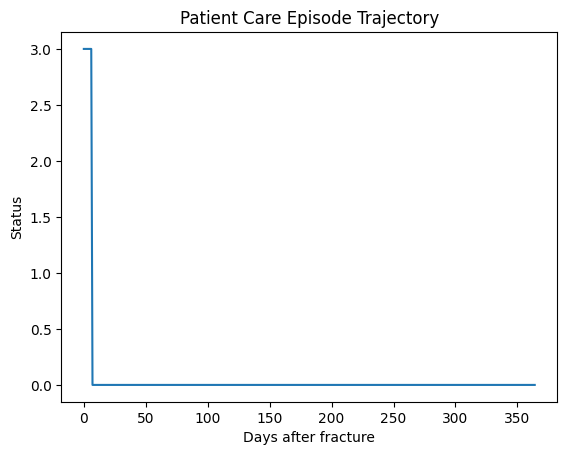

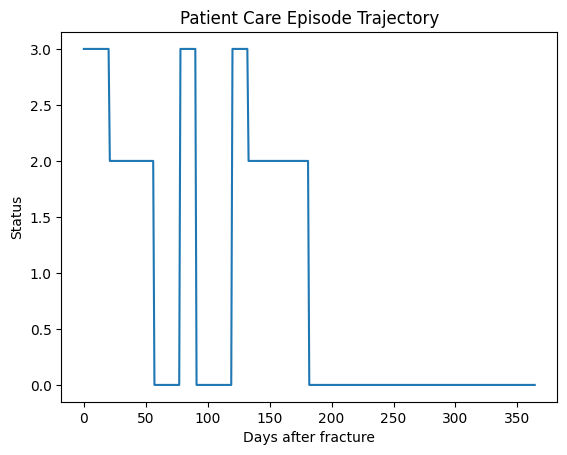

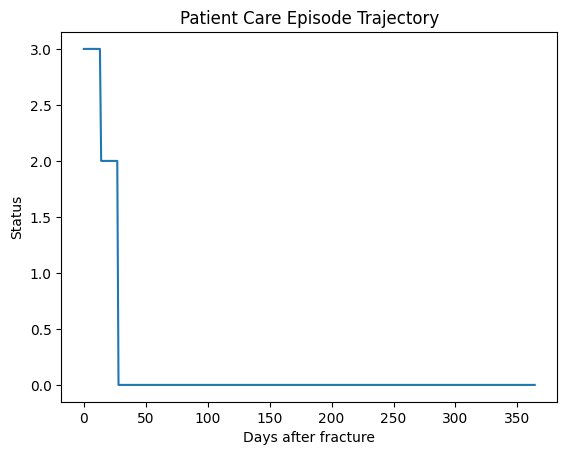

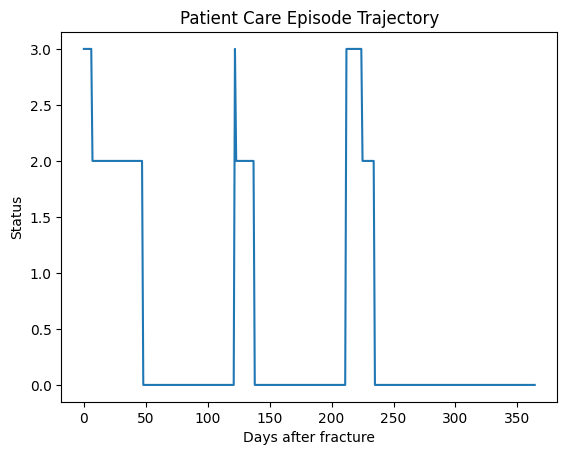

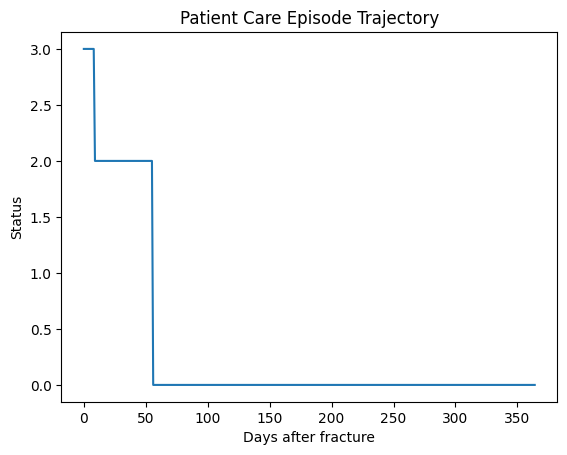

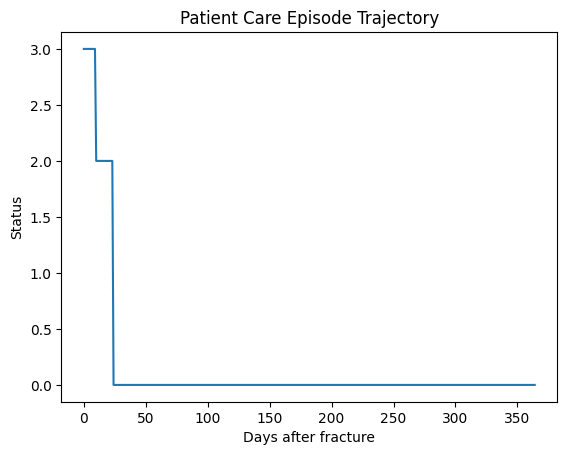

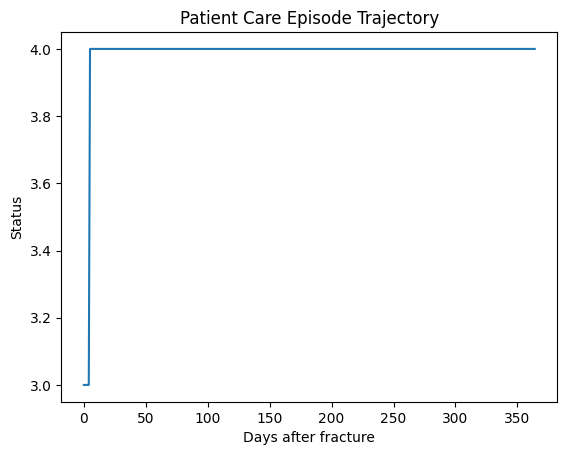

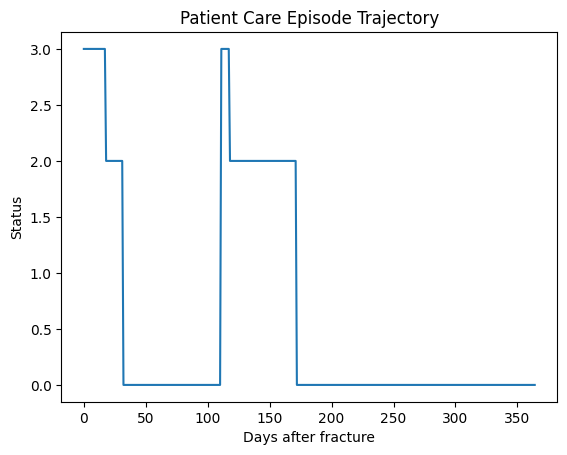

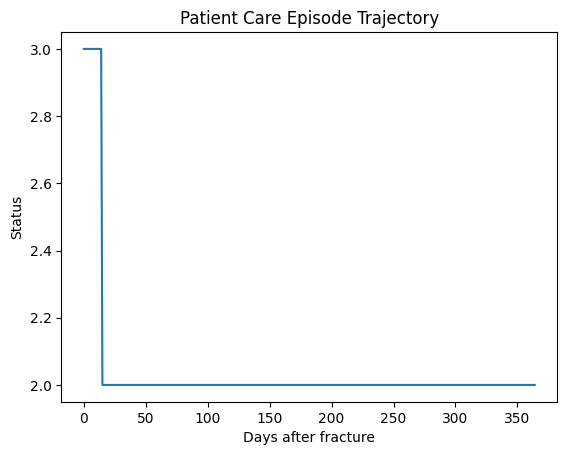

In [3]:
for i in range(0,10): #(0,515)
  patient = df.iloc[i,1:]
  plt.plot(patient.values)
  plt.title("Patient Care Episode Trajectory")
  plt.xlabel("Days after fracture")
  plt.ylabel("Status")
  plt.show()

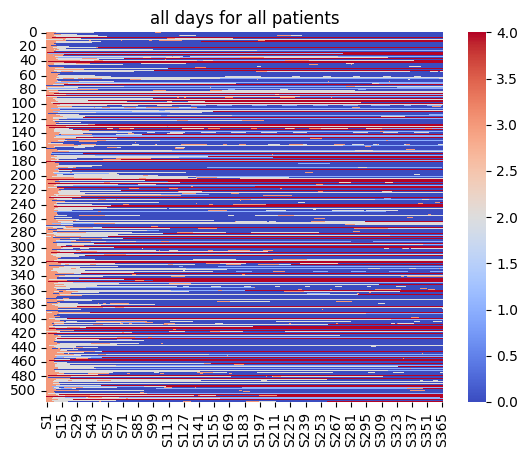

In [4]:
sns.heatmap(df.iloc[:,1:515], cmap="coolwarm", cbar=True)
plt.title("all days for all patients")
plt.show()

#Clustering

Based on samples, I decided to put them in 4 categories: stable situation, only gets better, only gets worse, unstable situation

In [5]:
def classify_patient(row):
    values = row.values
    start, end = values[0], values[-1]
    diffs = np.diff(values)

    num_changes = np.sum(diffs != 0)
    ever_worse = np.any(diffs > 0)   # goes worse
    ever_better = np.any(diffs < 0)  # gets better


    if num_changes == 0:
        return "Stable situation"
    elif (not ever_worse) and (end <= start):
        return "Only gets better"
    elif (not ever_better) and (end >= start):
        return "Only gets worse"
    else:
        return "Unstable situation"

# classification
df["cluster"] = df.drop("ID", axis=1).apply(classify_patient, axis=1)

# outcome
print(df["cluster"].value_counts())
df.head()

cluster
Unstable situation    278
Only gets better      199
Only gets worse        29
Stable situation       10
Name: count, dtype: int64


,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S357,S358,S359,S360,S361,S362,S363,S364,S365,cluster
0,1,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Unstable situation
1,2,3,3,3,3,3,3,3,0,0,...,0,0,0,0,0,0,0,0,0,Only gets better
2,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Unstable situation
3,4,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Only gets better
4,5,3,3,3,3,3,3,3,2,2,...,0,0,0,0,0,0,0,0,0,Unstable situation


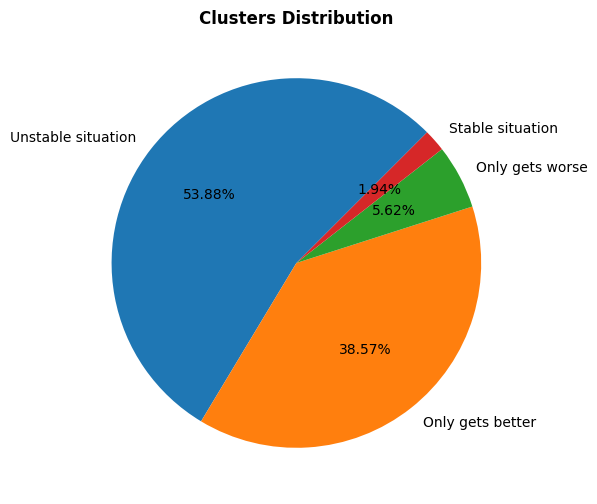

In [6]:
#Pie chart
plt.figure(figsize=(6,6))
plt.pie(
    df["cluster"].value_counts(),
    labels=df["cluster"].value_counts().index,
    autopct='%1.2f%%',
    startangle=45
)
plt.title("Clusters Distribution", fontweight='bold')
plt.show()

# Analyzing patients with a stable situation:

In [7]:
stable_situation = df[df["cluster"]=="Stable situation"]
stable_situation.head()

,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S357,S358,S359,S360,S361,S362,S363,S364,S365,cluster
31,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Stable situation
74,75,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Stable situation
88,89,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,Stable situation
130,131,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,Stable situation
140,141,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,Stable situation


***My takeaway:** After surgery they pass away or have returned home and still alive.*

S1
Pass away    6
Home         4
Name: count, dtype: int64


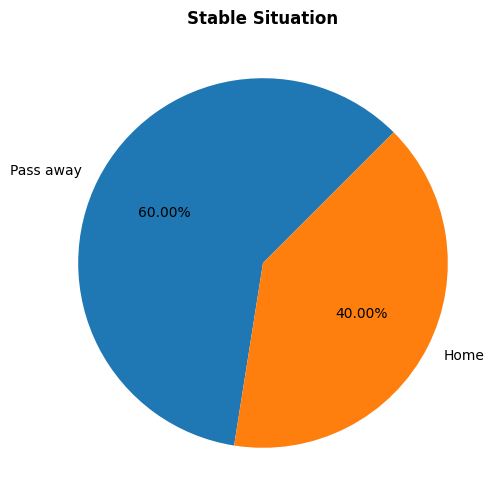

In [8]:
labels_map = {0: "Home", 4: "Pass away"}
print(stable_situation["S1"].replace(labels_map).value_counts())

#Pie chart
plt.figure(figsize=(6,6))

plt.pie(
    stable_situation["S1"].value_counts(),
    labels=["Home" if x == 0 else "Pass away" for x in stable_situation["S1"].value_counts().index],
    autopct='%1.2f%%',
    startangle=45
)
plt.title("Stable Situation", fontweight='bold')
plt.show()

The overall probability of get back at home without any problems or death after the surgery:

In [9]:
labels_map = {0: "home (%)", 4: "Pass away (%)"}
print((stable_situation["S1"].replace(labels_map).value_counts()) / (df.shape[0]-1)*100)

S1
Pass away (%)    1.165049
home (%)         0.776699
Name: count, dtype: float64


To find out how many of the patients who get back home after surgery would have a stable situation during a year:

In [10]:
labels_map = {0: "home", 4: "Pass away", 1:"nursing home" , 2:"primary care facility" , 3:"hospital" }

stable_counts = stable_situation["S1"].replace(labels_map).value_counts()
all_counts = df["S1"].replace(labels_map).value_counts()

stable_home = stable_counts.get("home", 0)
all_home = all_counts.get("home", 0)

percentage = (stable_home / all_home * 100)

print(f"Home in stable_situation: {stable_home}")
print(f"Home in all patients: {all_home}")
print(f"Percentage: {percentage:.2f}%")

Home in stable_situation: 4
Home in all patients: 9
Percentage: 44.44%


***My takeaway:** It's barely happened that a patient gets back home after surgery, and more than 50% of these situations would be changed, so I think it's better to keep them in stage 1: "nursing home" rather than staying in the home for at least ? days*

In [11]:
df[df["S1"]==0]["cluster"].value_counts()

,count
cluster,
Unstable situation,5
Stable situation,4


In [12]:
df[(df["S1"] == 0) & (df["cluster"] == "Unstable situation")]

,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S357,S358,S359,S360,S361,S362,S363,S364,S365,cluster
59,60,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Unstable situation
105,106,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Unstable situation
108,109,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Unstable situation
162,163,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Unstable situation
371,372,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Unstable situation


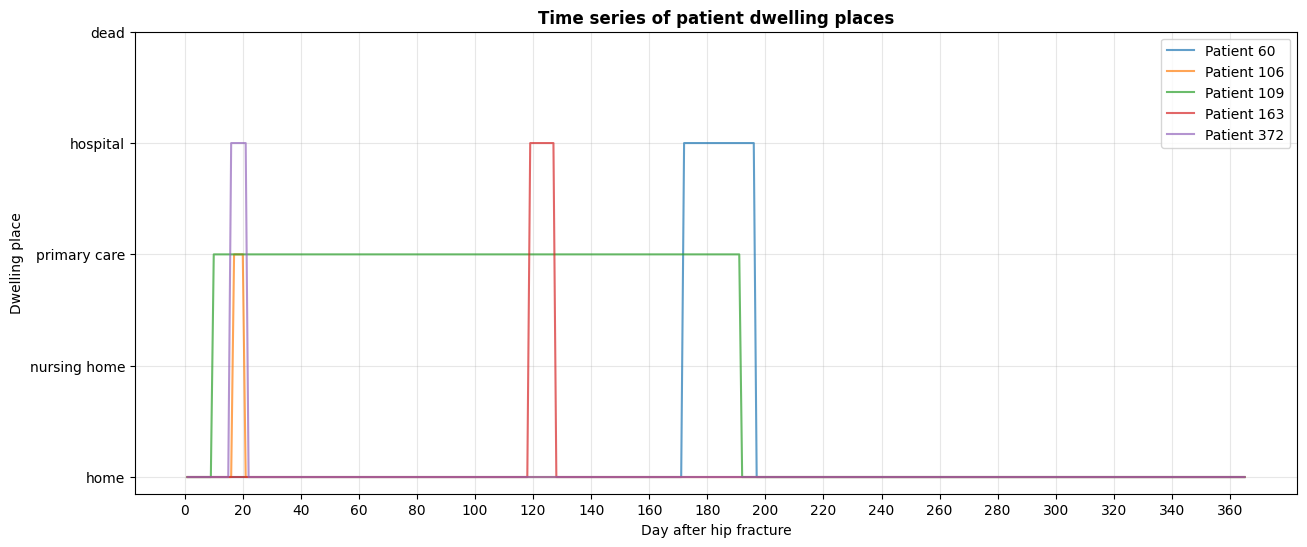

In [13]:
subset = df[(df["S1"] == 0) & (df["cluster"] == "Unstable situation")]

plt.figure(figsize=(15,6))

for idx, row in subset.iterrows():
    values = row.drop(["ID", "cluster"]).values
    plt.plot(range(1, 366), values, alpha=0.7, label=f"Patient {row['ID']}")

plt.xlabel("Day after hip fracture")
plt.ylabel("Dwelling place")
plt.title("Time series of patient dwelling places", fontweight='bold')

plt.yticks([0,1,2,3,4], ["home","nursing home","primary care","hospital","dead"])
plt.xticks(np.arange(0, 366, 20))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

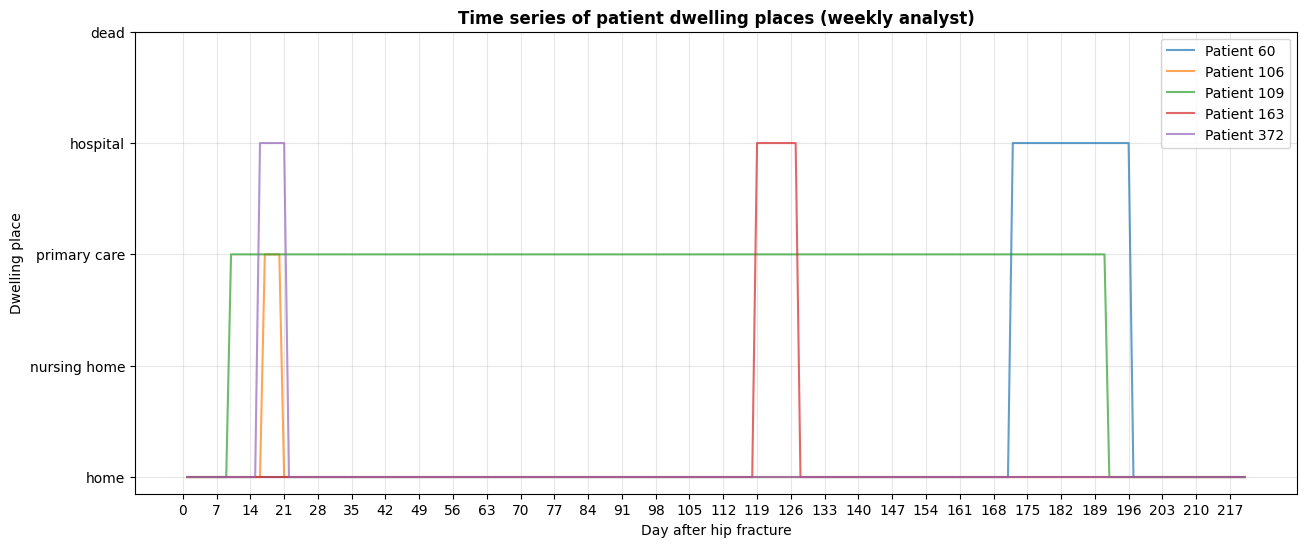

In [14]:
# select only first 220 days
S_cols = [f"S{i}" for i in range(1, 221)]

subset = df[(df["S1"] == 0) & (df["cluster"] == "Unstable situation")]

plt.figure(figsize=(15,6))

for idx, row in subset.iterrows():
    values = row[S_cols].values.astype(int)
    plt.plot(range(1, len(S_cols)+1), values, alpha=0.7, label=f"Patient {row['ID']}")

plt.xlabel("Day after hip fracture")
plt.ylabel("Dwelling place")
plt.title("Time series of patient dwelling places (weekly analyst)", fontweight='bold')

plt.yticks([0,1,2,3,4], ["home","nursing home","primary care","hospital","dead"])
plt.xticks(np.arange(0, 221, 7))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#### **Main Results:** It's barely happened that a patient gets back home after surgery, and more than 50% of these situations would be changed, so I think it's better to keep them in stage 1: "nursing home" rather than let them back to home for at least 2 weeks, cause I think most things show up in week 1 and 2, but now we see the result as a stage-changing in week 3.

# Analyzing patients who only gets worse:

In [15]:
OGW = df[df["cluster"]=="Only gets worse"]
OGW.shape

(29, 367)

How many pass away:

In [16]:
OGW[OGW["S365"]==4].shape[0]

29

***My takeaway:** So, all the patients in this category pass away in first year.*

How many jumps happened and when:

In [17]:
# Function to get jumps info
def get_jumps(row):
    values = row.values
    diffs = np.diff(values)

    jump_days = np.where(diffs > 0)[0] + 2  # +2 : diff shifts (1) and day starts at S1
    num_jumps = len(jump_days)

    return pd.Series([num_jumps, jump_days], index=["num_jumps", "jump_days"])

# delet ID and cluster
jump_info_OGW = OGW.drop(["ID", "cluster"], axis=1).apply(get_jumps, axis=1)

# Show result
jump_info_OGW.head()

,num_jumps,jump_days
7,1,[6]
28,1,[2]
30,1,[17]
40,1,[3]
42,1,[17]


In [18]:
print(jump_info_OGW["num_jumps"].value_counts())

num_jumps
1    29
Name: count, dtype: int64


***My takeaway:** It shows that they all died by 1 change in their situations.*

In [19]:
print(OGW["S1"].replace(labels_map).value_counts())

S1
hospital                 28
primary care facility     1
Name: count, dtype: int64


In [20]:
labels_map = {0: "home", 4: "Pass away", 1:"nursing home" , 2:"primary care facility" , 3:"hospital" }

OGW_counts = OGW["S1"].replace(labels_map).value_counts()
all_counts = df["S1"].replace(labels_map).value_counts()

OGW_hospital = OGW_counts.get("hospital", 0)
all_hospital = all_counts.get("hospital", 0)

percentage = (OGW_hospital / all_hospital * 100)

print(f"Hospitalized in first day through only get worse group: {OGW_hospital}")
print(f"Hospitalized in first day through all patients: {all_hospital}")
print(f"Percentage: {percentage:.2f}%")

Hospitalized in first day through only get worse group: 28
Hospitalized in first day through all patients: 493
Percentage: 5.68%


In [21]:
df[df["S1"]==3]["cluster"].value_counts()

,count
cluster,
Unstable situation,266
Only gets better,199
Only gets worse,28


In %:

In [22]:
(df[df["S1"]==3]["cluster"].value_counts()/ (df[df["S1"]==3]["cluster"].value_counts().sum())*100).round(2)

,count
cluster,
Unstable situation,53.96
Only gets better,40.37
Only gets worse,5.68


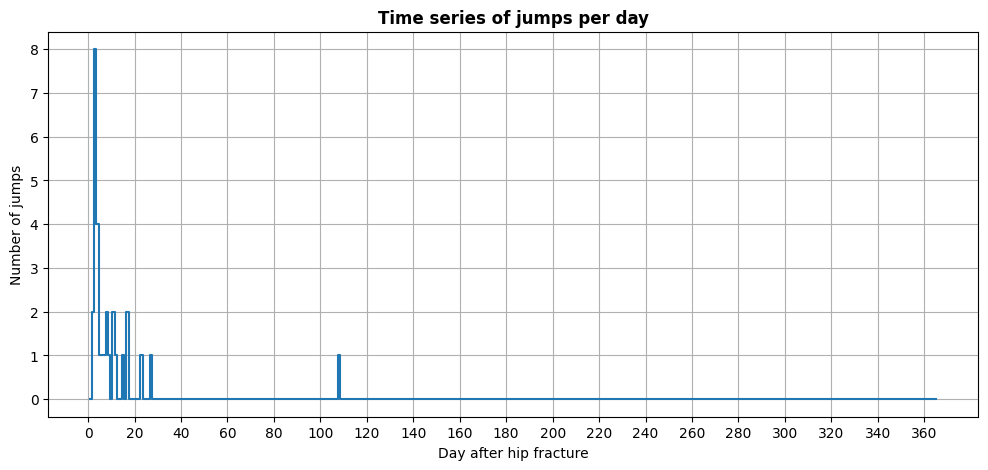

In [23]:
from collections import Counter

all_jump_days = [day for sublist in jump_info_OGW["jump_days"] for day in sublist]
day_counts = Counter(all_jump_days)

days = np.arange(1, 366)
jump_per_day = [day_counts.get(d, 0) for d in days]

plt.figure(figsize=(12,5))
plt.plot(days, jump_per_day, drawstyle='steps-mid')
plt.xlabel("Day after hip fracture")
plt.ylabel("Number of jumps")
plt.title("Time series of jumps per day", fontweight='bold')

max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 20)
plt.xticks(xticks)

plt.grid(True)
plt.show()


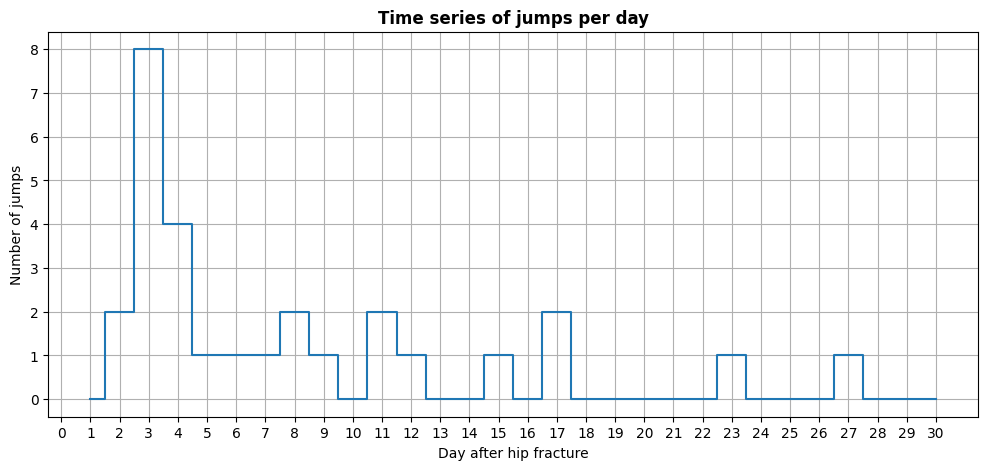

In [24]:
from collections import Counter

all_jump_days = [day for sublist in jump_info_OGW["jump_days"] for day in sublist]
day_counts = Counter(all_jump_days)

days = np.arange(1, 31)
jump_per_day = [day_counts.get(d, 0) for d in days]

plt.figure(figsize=(12,5))
plt.plot(days, jump_per_day, drawstyle='steps-mid')
plt.xlabel("Day after hip fracture")
plt.ylabel("Number of jumps")
plt.title("Time series of jumps per day", fontweight='bold')

max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 1)
plt.xticks(xticks)

plt.grid(True)
plt.show()


#### **Main Result:** In the "only gets worse" category, which is 5.6% of our patients, they would die mostly during the first month, especially in week 1

# Analyzing patients who only gets better:

In [25]:
OGB = df[df["cluster"]=="Only gets better"]
OGB.head()

,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S357,S358,S359,S360,S361,S362,S363,S364,S365,cluster
1,2,3,3,3,3,3,3,3,0,0,...,0,0,0,0,0,0,0,0,0,Only gets better
3,4,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Only gets better
5,6,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Only gets better
6,7,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Only gets better
9,10,3,3,3,3,3,3,3,3,3,...,2,2,2,2,2,2,2,2,2,Only gets better


Patients stage in Day 1:

In [26]:
print("Total patients who only gets better: ", OGB.shape[0])
print("home: ", OGB[OGB["S1"]==0].shape[0])
print("nursing home: ", OGB[OGB["S1"]==1].shape[0])
print("primary care facility: ", OGB[OGB["S1"]==2].shape[0])
print("hospital: ", OGB[OGB["S1"]==3].shape[0])

Total patients who only gets better:  199
home:  0
nursing home:  0
primary care facility:  0
hospital:  199


***My takeaway:** patients who "only get better" all got hospitalized on day 1.*

How many patients got hospitalized on day 1 / what percentage % of them are in the OGB category?

In [27]:
labels_map = {0: "home", 4: "Pass away", 1:"nursing home" , 2:"primary care facility" , 3:"hospital" }

OGB_counts = OGB["S1"].replace(labels_map).value_counts()
all_counts = df["S1"].replace(labels_map).value_counts()

OGB_hospital = OGB_counts.get("hospital", 0)
all_hospital = all_counts.get("hospital", 0)

percentage = (OGB_hospital / all_hospital * 100)

print(f"Hospitalized in first day through only get worse group: {OGB_hospital}")
print(f"Hospitalized in first day through all patients: {all_hospital}")
print(f"Percentage: {percentage:.2f}%")

Hospitalized in first day through only get worse group: 199
Hospitalized in first day through all patients: 493
Percentage: 40.37%


In [28]:
df[df["S1"]==3]["cluster"].value_counts()

,count
cluster,
Unstable situation,266
Only gets better,199
Only gets worse,28


Patients stage in Day 365:

In [29]:
print("Total patients who only gets better: ", OGB.shape[0])
print("home: ", OGB[OGB["S365"]==0].shape[0])
print("nursing home: ", OGB[OGB["S365"]==1].shape[0])
print("primary care facility: ", OGB[OGB["S365"]==2].shape[0])
print("hospital: ", OGB[OGB["S365"]==3].shape[0])

Total patients who only gets better:  199
home:  141
nursing home:  31
primary care facility:  27
hospital:  0


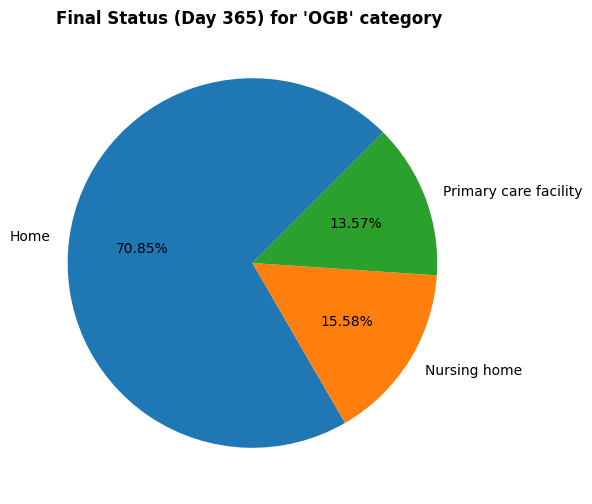

In [30]:
#pie chart
labels = ["Home", "Nursing home", "Primary care facility"]
sizes = [
    OGB[OGB["S365"]==0].shape[0],
    OGB[OGB["S365"]==1].shape[0],
    OGB[OGB["S365"]==2].shape[0]
]


plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.2f%%',
    startangle=45
)
plt.title("Final Status (Day 365) for 'OGB' category ", fontweight='bold')
plt.show()

## patients in the OGB category:

How many times jump and when




In [31]:
# Function to get jumps info
def get_jumps(row):
    values = row.values
    diffs = np.diff(values)

    jump_days = np.where(diffs < 0)[0] + 2  # +2 : diff shifts (1) and day starts at S1
    num_jumps = len(jump_days)

    return pd.Series([num_jumps, jump_days], index=["num_jumps", "jump_days"])

# delet ID and cluster
jump_info_OGB = OGB[OGB["S365"]==0].drop(["ID", "cluster"], axis=1).apply(get_jumps, axis=1)

# Show result
jump_info_OGB.head()

,num_jumps,jump_days
1,1,[8]
3,2,"[15, 29]"
5,2,"[10, 57]"
6,2,"[11, 25]"
14,2,"[10, 43]"


***My takeaway:** I consider patients who get better by 3 changes in their situation as outliers.

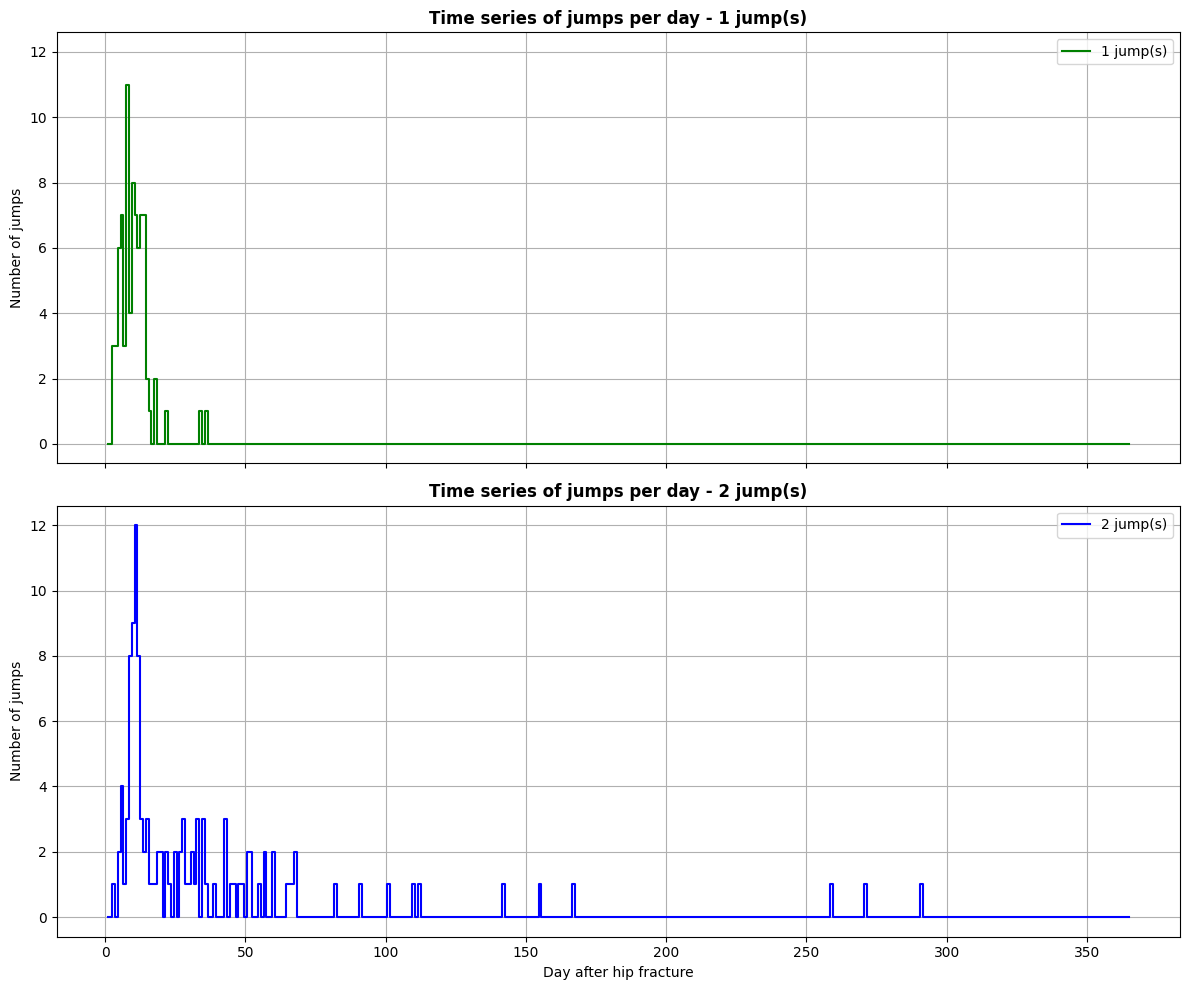

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(12,10), sharex=True, sharey=True)

colors = {1: "green", 2: "blue"}

for ax, i in zip(axes, [1,2]):
    all_jump_days = [day for sublist in jump_info_OGB[jump_info_OGB["num_jumps"]==i]["jump_days"] for day in sublist]
    day_counts = Counter(all_jump_days)

    days = np.arange(1, 366)
    jump_per_day = [day_counts.get(d, 0) for d in days]

    ax.plot(days, jump_per_day, drawstyle='steps-mid', color=colors[i], label=f"{i} jump(s)")
    ax.set_ylabel("Number of jumps")
    ax.set_title(f"Time series of jumps per day - {i} jump(s)", fontweight='bold')
    ax.grid(True)
    ax.legend()

max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 50)
plt.xticks(xticks)
axes[-1].set_xlabel("Day after hip fracture")

plt.tight_layout()
plt.show()

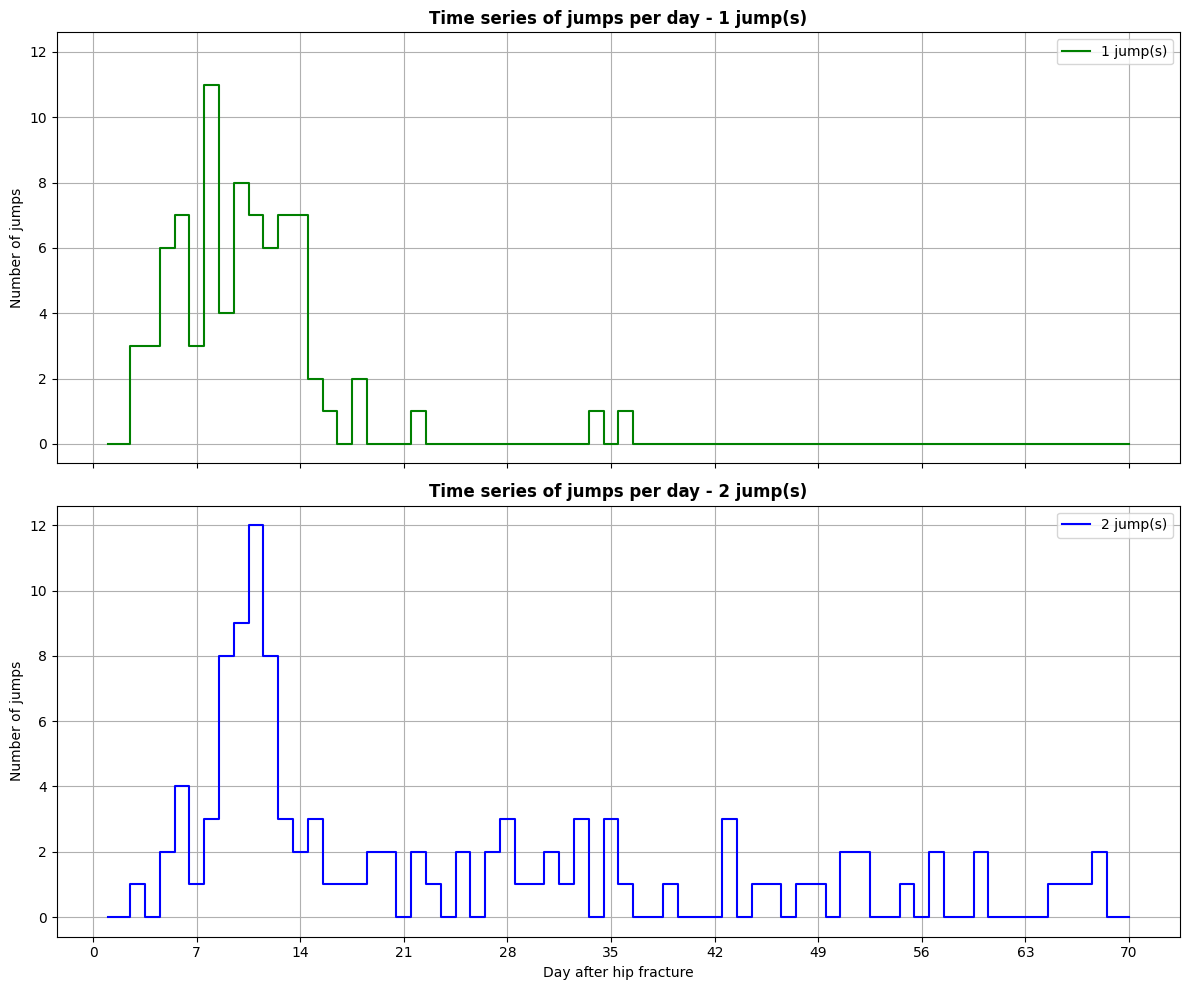

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(12,10), sharex=True, sharey=True)

colors = {1: "green", 2: "blue"}

for ax, i in zip(axes, [1,2]):
    all_jump_days = [day for sublist in jump_info_OGB[jump_info_OGB["num_jumps"]==i]["jump_days"] for day in sublist]
    day_counts = Counter(all_jump_days)

    days = np.arange(1, 71)
    jump_per_day = [day_counts.get(d, 0) for d in days]

    ax.plot(days, jump_per_day, drawstyle='steps-mid', color=colors[i], label=f"{i} jump(s)")
    ax.set_ylabel("Number of jumps")
    ax.set_title(f"Time series of jumps per day - {i} jump(s)", fontweight='bold')
    ax.grid(True)
    ax.legend()

max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 7)
plt.xticks(xticks)
axes[-1].set_xlabel("Day after hip fracture")

plt.tight_layout()
plt.show()

***My takeaway:** in hospitalized patients whose situation changed once, this change mostly occurred during 3 weeks.

Analyse patients who get better by "2 jumps" deeper:

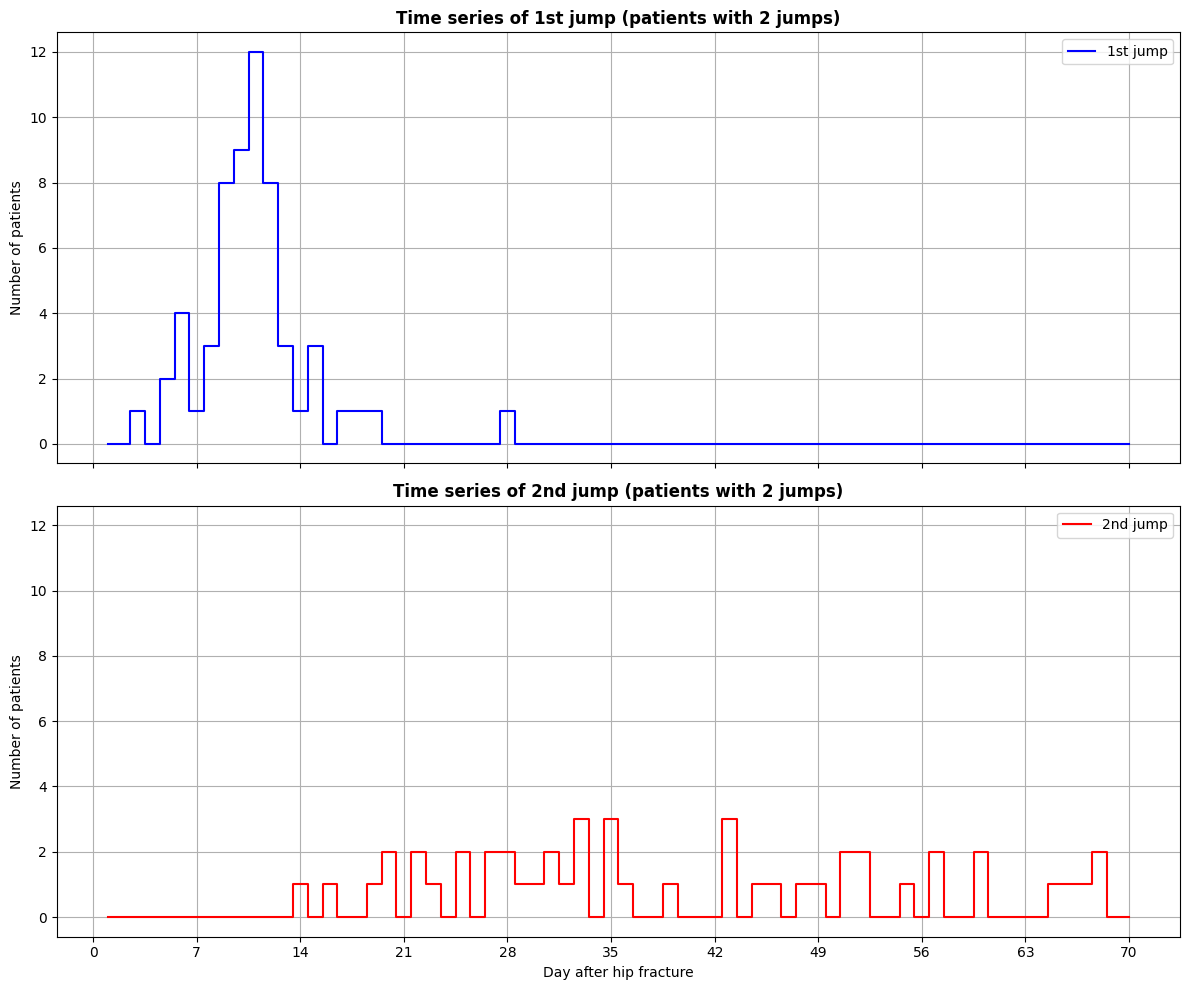

In [34]:
from collections import Counter


two_jump_patients = jump_info_OGB[jump_info_OGB["num_jumps"] == 2]


first_jumps = [days[0] for days in two_jump_patients["jump_days"]]
second_jumps = [days[1] for days in two_jump_patients["jump_days"]]


first_counts = Counter(first_jumps)
second_counts = Counter(second_jumps)


days = np.arange(1, 71)
first_jump_per_day = [first_counts.get(d, 0) for d in days]
second_jump_per_day = [second_counts.get(d, 0) for d in days]

fig, axes = plt.subplots(2, 1, figsize=(12,10), sharex=True, sharey=True)

#first jump chart
axes[0].plot(days, first_jump_per_day, drawstyle='steps-mid', color="blue", label="1st jump")
axes[0].set_ylabel("Number of patients")
axes[0].set_title("Time series of 1st jump (patients with 2 jumps)", fontweight='bold')
axes[0].grid(True)
axes[0].legend()

#second junmp chart
axes[1].plot(days, second_jump_per_day, drawstyle='steps-mid', color="red", label="2nd jump")
axes[1].set_ylabel("Number of patients")
axes[1].set_title("Time series of 2nd jump (patients with 2 jumps)", fontweight='bold')
axes[1].grid(True)
axes[1].legend()

#be in same scale
max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 7)
plt.xticks(xticks)
axes[-1].set_xlabel("Day after hip fracture")

plt.tight_layout()
plt.show()


***My takeaway:** first dwelling changes happened during the first 3 weeks, and mostly they get better within 70days*

#### **Main Result:** for patients in the OGB group, the first 3weeks are really important, during this time they leave the hospital (and would get better during 2 months).

Where they end up after each jump(s)

In [35]:
S_cols = [c for c in OGB.columns if str(c).startswith("S")]
jump_info_gb = OGB[S_cols].apply(get_jumps, axis=1)

jump_info_gb = pd.concat([OGB[["ID","cluster"]], jump_info_gb], axis=1)


labels_map = {0: "home",
              1: "nursing home",
              2: "primary care facility",
              3: "hospital",
              4: "Pass away"}

jump_info_gb["final_stage"] = OGB["S365"].astype(int).map(labels_map)

print(jump_info_gb.groupby("num_jumps")["final_stage"].value_counts())

num_jumps  final_stage          
1          home                     80
           primary care facility    27
           nursing home              7
2          home                     59
           nursing home             24
3          home                      2
Name: count, dtype: int64


In [36]:
print(jump_info_gb["num_jumps"].value_counts())

num_jumps
1    114
2     83
3      2
Name: count, dtype: int64


persntage analyse:

In [37]:
print(jump_info_gb.groupby("num_jumps")["final_stage"].value_counts()/jump_info_gb["num_jumps"].value_counts()*100)

num_jumps  final_stage          
1          home                      70.175439
           primary care facility     23.684211
           nursing home               6.140351
2          home                      71.084337
           nursing home              28.915663
3          home                     100.000000
Name: count, dtype: float64


***My takeaway:** patients with 3 jumps are just 2, so I consider them as outliers.*

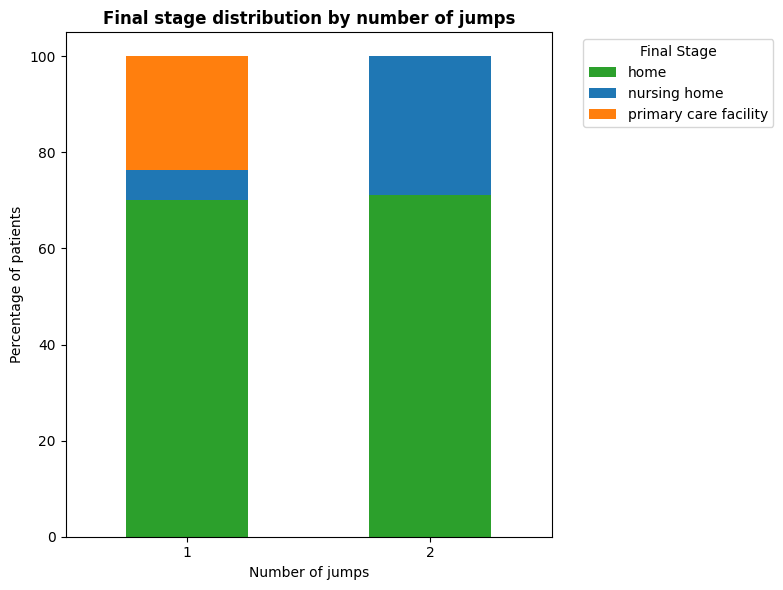

In [38]:
import matplotlib.pyplot as plt

# Filter only 1 and 2 jumps
jump_filtered = jump_info_gb[jump_info_gb["num_jumps"].isin([1,2])]

# Count patients by num_jumps and final_stage
counts = jump_filtered.groupby(["num_jumps", "final_stage"]).size().unstack(fill_value=0)

# Normalize to percentage for stacked bar
counts_percent = counts.div(counts.sum(axis=1), axis=0) * 100


colors_map = {
    "home": "#2ca02c",             # green
    "nursing home": "#1f77b4",     # blue
    "primary care facility": "#ff7f0e",  # orange
    "hospital": "#d62728",         # red
    "Pass away": "#000000"         # black
}

# Plot stacked bar with thinner bars
ax = counts_percent.plot(
    kind="bar",
    stacked=True,
    color=[colors_map[col] for col in counts_percent.columns],
    figsize=(8,6),
    width=0.5  # thinner bars
)

plt.ylabel("Percentage of patients")
plt.xlabel("Number of jumps")
plt.title("Final stage distribution by number of jumps", fontweight='bold')
plt.xticks(rotation=0)  # horizontal labels
plt.legend(title="Final Stage", bbox_to_anchor=(1.05, 1))
#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Analyze duration between jumps:

In [39]:
def get_jumps(row):
    values = row.values
    diffs = np.diff(values)

    jump_days = np.where(diffs < 0)[0] + 2  # +2 chon diff shift mide
    num_jumps = len(jump_days)

    # calculate durations between jumps
    if num_jumps > 1:
        durations = np.diff(jump_days)
    else:
        durations = np.array([])

    return pd.Series([num_jumps, jump_days, durations],
                     index=["num_jumps", "jump_days", "durations"])

S_cols = [c for c in OGB.columns if str(c).startswith("S")]
jump_info_gb = OGB[S_cols].apply(get_jumps, axis=1)
jump_info_gb = pd.concat([OGB[["ID","cluster"]], jump_info_gb], axis=1)
jump_info_gb.head()

,ID,cluster,num_jumps,jump_days,durations
1,2,Only gets better,1,[8],[]
3,4,Only gets better,2,"[15, 29]",[14]
5,6,Only gets better,2,"[10, 57]",[47]
6,7,Only gets better,2,"[11, 25]",[14]
9,10,Only gets better,1,[16],[]


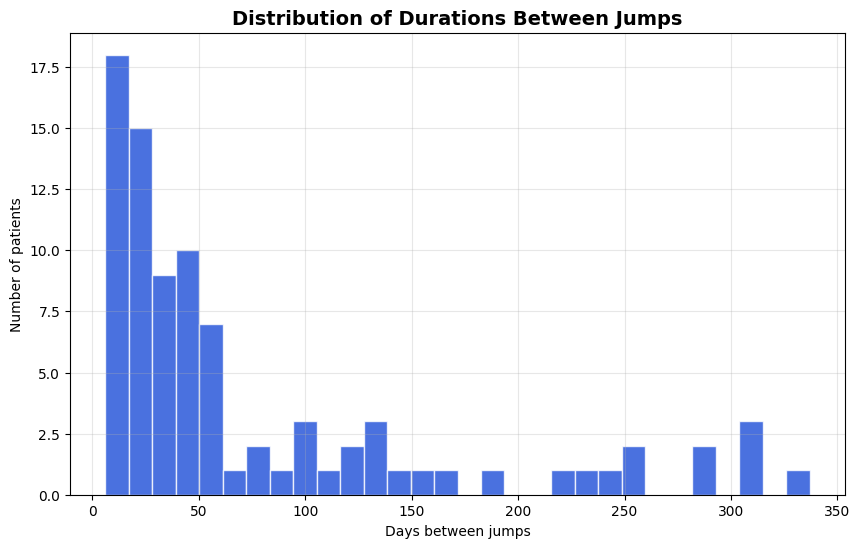

In [40]:
import matplotlib.pyplot as plt

# durations
all_durations = jump_info_gb['durations'].explode().dropna().astype(int)

plt.figure(figsize=(10,6))
plt.hist(all_durations, bins=30, color="#1d4ed8", alpha=0.8, edgecolor="white")
plt.xlabel("Days between jumps")
plt.ylabel("Number of patients")
plt.title("Distribution of Durations Between Jumps", fontsize=14, fontweight="bold")
plt.grid(alpha=0.3)
plt.show()

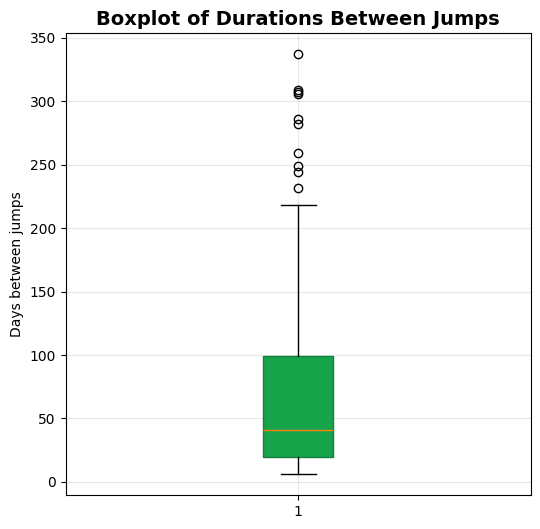

In [41]:
plt.figure(figsize=(6,6))
plt.boxplot(all_durations, vert=True, patch_artist=True,
            boxprops=dict(facecolor="#16a34a", color="#15803d"))
plt.ylabel("Days between jumps")
plt.title("Boxplot of Durations Between Jumps", fontsize=14, fontweight="bold")
plt.grid(alpha=0.3)
plt.show()

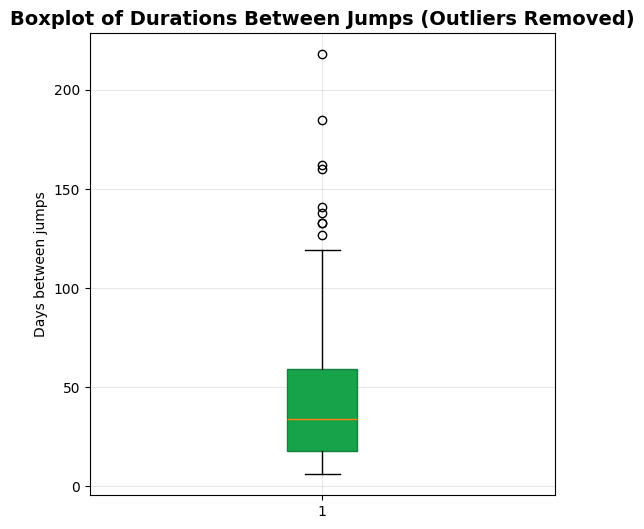

In [42]:
import numpy as np

# durations (flattened)
all_durations = jump_info_gb['durations'].explode().dropna().astype(int)

# IQR filtering
Q1 = np.percentile(all_durations, 25)
Q3 = np.percentile(all_durations, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

durations_no_outliers = all_durations[(all_durations >= lower_bound) & (all_durations <= upper_bound)]

# Boxplot after removing outliers
plt.figure(figsize=(6,6))
plt.boxplot(durations_no_outliers, vert=True, patch_artist=True,
            boxprops=dict(facecolor="#16a34a", color="#15803d"))
plt.ylabel("Days between jumps")
plt.title("Boxplot of Durations Between Jumps (Outliers Removed)", fontsize=14, fontweight="bold")
plt.grid(alpha=0.3)
plt.show()

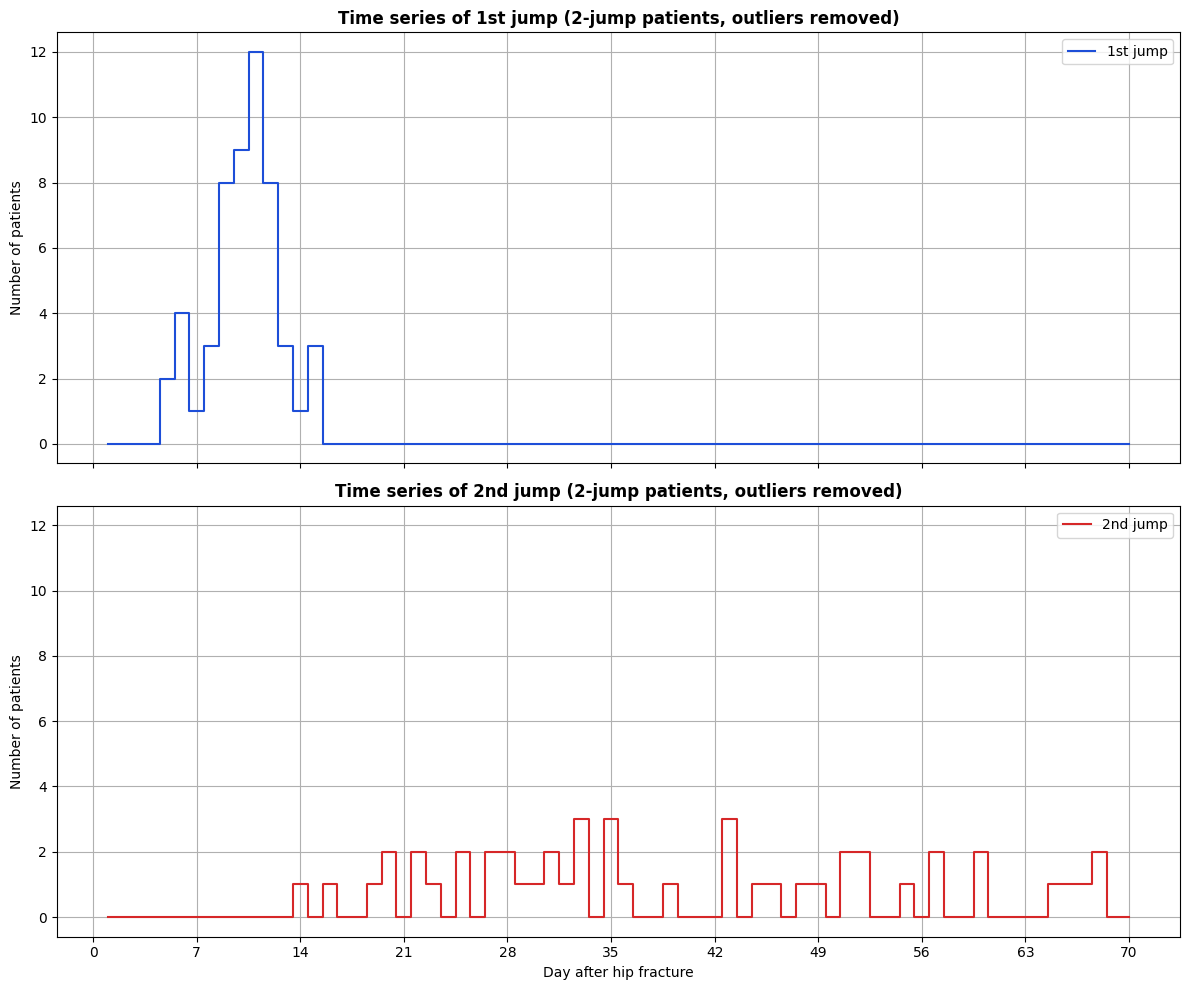

In [43]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Select patients with exactly 2 jumps
two_jump_patients = jump_info_OGB[jump_info_OGB["num_jumps"] == 2]

# Extract first and second jump days
first_jumps = [days[0] for days in two_jump_patients["jump_days"]]
second_jumps = [days[1] for days in two_jump_patients["jump_days"]]

# --- Outlier filtering (IQR method) ---
def remove_outliers(data):
    data = np.array(data)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

first_jumps_clean = remove_outliers(first_jumps)
second_jumps_clean = remove_outliers(second_jumps)

# Count occurrences after removing outliers
first_counts = Counter(first_jumps_clean)
second_counts = Counter(second_jumps_clean)

# Make sure day range fits your study window (e.g. first 70 days)
days = np.arange(1, 71)
first_jump_per_day = [first_counts.get(d, 0) for d in days]
second_jump_per_day = [second_counts.get(d, 0) for d in days]

# --- Plot ---
fig, axes = plt.subplots(2, 1, figsize=(12,10), sharex=True, sharey=True)

# First jump chart
axes[0].plot(days, first_jump_per_day, drawstyle='steps-mid',
             color="#1d4ed8", label="1st jump")   # vivid blue
axes[0].set_ylabel("Number of patients")
axes[0].set_title("Time series of 1st jump (2-jump patients, outliers removed)", fontweight='bold')
axes[0].grid(True)
axes[0].legend()

# Second jump chart
axes[1].plot(days, second_jump_per_day, drawstyle='steps-mid',
             color="#d62728", label="2nd jump")   # vivid red
axes[1].set_ylabel("Number of patients")
axes[1].set_title("Time series of 2nd jump (2-jump patients, outliers removed)", fontweight='bold')
axes[1].grid(True)
axes[1].legend()

# Common x-axis
max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 7)
plt.xticks(xticks)
axes[-1].set_xlabel("Day after hip fracture")

plt.tight_layout()
plt.show()


Getting virtual output by ChatGPT

In [44]:
import plotly.graph_objects as go

# Example data
labels = ["Hospital", "Home", "Nursing", "Primary care"]
# Step 1: Hospital to somewhere
sources = [0, 0, 0]   # Hospital
targets = [1, 2, 3]   # Home, Nursing, Primary care
values  = [80, 7, 27]

# Step 2: From Primary care to somewhere
sources += [3, 3]
targets += [1, 2]
values  += [10, 5]

colors = ['#1f77b4', '#2563eb', '#1d4ed8', '#16a34a', '#15803d']

# Alluvial diagram with two steps (like Sankey but layered)
fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=20,
        thickness=25,
        line=dict(color="black", width=0.5),
        label=labels,
        color="lightgray"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=colors
    )
))

fig.update_layout(title_text="Alluvial Diagram of Patient Transitions", font_size=16)
fig.show()


# Analyzing patients with unstable situation:

In [45]:
unstable_situation = df[df["cluster"]=="Unstable situation"]
unstable_situation.head()

,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S357,S358,S359,S360,S361,S362,S363,S364,S365,cluster
0,1,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Unstable situation
2,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Unstable situation
4,5,3,3,3,3,3,3,3,2,2,...,0,0,0,0,0,0,0,0,0,Unstable situation
8,9,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Unstable situation
10,11,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,Unstable situation


Patients stage in Day 1:

In [46]:
print("Total patients who unstable situation: ", unstable_situation.shape[0])
print("home: ", unstable_situation[unstable_situation["S1"]==0].shape[0])
print("nursing home: ", unstable_situation[unstable_situation["S1"]==1].shape[0])
print("primary care facility: ", unstable_situation[unstable_situation["S1"]==2].shape[0])
print("hospital: ", unstable_situation[unstable_situation["S1"]==3].shape[0])

Total patients who unstable situation:  278
home:  5
nursing home:  0
primary care facility:  7
hospital:  266


How many patients got hospitalized on day 1 / what percentage % of them are in the unstable situation?

In [47]:
labels_map = {0: "home", 4: "Pass away", 1:"nursing home" , 2:"primary care facility" , 3:"hospital" }

unstable_situation_counts = unstable_situation["S1"].replace(labels_map).value_counts()
all_counts = df["S1"].replace(labels_map).value_counts()

unstable_situation_hospital = unstable_situation_counts.get("hospital", 0)
all_hospital = all_counts.get("hospital", 0)

percentage = (unstable_situation_hospital / all_hospital * 100)

print(f"Hospitalized in first day through unstable situation: {unstable_situation_hospital}")
print(f"Hospitalized in first day through all patients: {all_hospital}")
print(f"Percentage: {percentage:.2f}%")

Hospitalized in first day through unstable situation: 266
Hospitalized in first day through all patients: 493
Percentage: 53.96%


In [48]:
df[df["S1"]==3]["cluster"].value_counts()

,count
cluster,
Unstable situation,266
Only gets better,199
Only gets worse,28


Patients stage in Day 365:

In [49]:
print("Total patients who unstable situation: ", unstable_situation.shape[0])
print("home: ", unstable_situation[unstable_situation["S365"]==0].shape[0])
print("nursing home: ", unstable_situation[unstable_situation["S365"]==1].shape[0])
print("primary care facility: ", unstable_situation[unstable_situation["S365"]==2].shape[0])
print("hospital: ", unstable_situation[unstable_situation["S365"]==3].shape[0])

Total patients who unstable situation:  278
home:  125
nursing home:  26
primary care facility:  26
hospital:  3


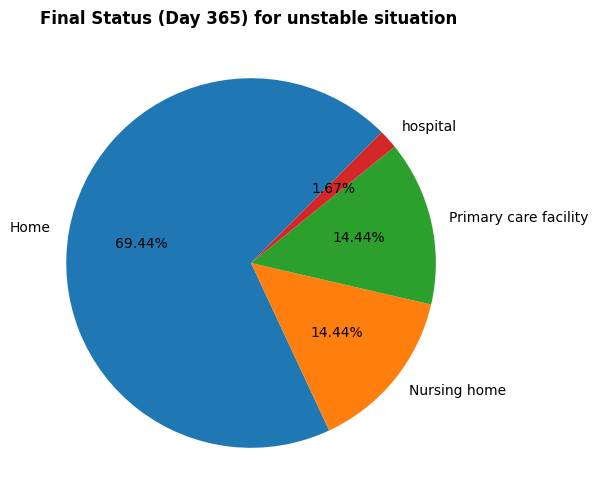

In [50]:
#pie chart
labels = ["Home", "Nursing home", "Primary care facility", "hospital"]
sizes = [
    unstable_situation[unstable_situation["S365"]==0].shape[0],
    unstable_situation[unstable_situation["S365"]==1].shape[0],
    unstable_situation[unstable_situation["S365"]==2].shape[0],
    unstable_situation[unstable_situation["S365"]==3].shape[0]
]


plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.2f%%',
    startangle=45
)
plt.title("Final Status (Day 365) for unstable situation ", fontweight='bold')
plt.show()

How many times jump and when

In [51]:
# Function to get jumps info
def get_jumps(row):
    values = row.values
    diffs = np.diff(values)

    jump_days = np.where(diffs < 0)[0] + 2  # +2 : diff shifts (1) and day starts at S1
    num_jumps = len(jump_days)

    return pd.Series([num_jumps, jump_days], index=["num_jumps", "jump_days"])

# delet ID and cluster
jump_info_unstable_situation = unstable_situation[unstable_situation["S365"]==0].drop(["ID", "cluster"], axis=1).apply(get_jumps, axis=1)

# Show result
jump_info_unstable_situation.head()

,num_jumps,jump_days
0,3,"[10, 45, 107]"
2,5,"[22, 58, 92, 134, 183]"
4,6,"[8, 49, 124, 139, 226, 236]"
8,4,"[19, 33, 119, 173]"
13,4,"[10, 58, 98, 177]"


In [52]:
S_cols = [c for c in OGB.columns if str(c).startswith("S")]
jump_info_unstable_situation = unstable_situation[S_cols].apply(get_jumps, axis=1)

jump_info_unstable_situation = pd.concat([unstable_situation[["ID","cluster"]], jump_info_unstable_situation], axis=1)


labels_map = {0: "home",
              1: "nursing home",
              2: "primary care facility",
              3: "hospital",
              4: "Pass away"}

jump_info_unstable_situation["final_stage"] = unstable_situation["S365"].astype(int).map(labels_map)

print(jump_info_unstable_situation.groupby("num_jumps")["final_stage"].value_counts())

num_jumps  final_stage          
1          Pass away                60
           home                      5
           primary care facility     2
2          home                     24
           Pass away                16
           primary care facility    10
           nursing home              1
3          home                     46
           Pass away                12
           nursing home             12
           primary care facility     3
           hospital                  2
4          home                     19
           nursing home              3
           primary care facility     3
           Pass away                 2
           hospital                  1
5          home                      8
           Pass away                 4
           primary care facility     2
           nursing home              1
6          home                      8
           nursing home              6
           Pass away                 2
           primary care facilit

/tmp/ipython-input-3023466572.py:46: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipython-input-3023466572.py:59: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



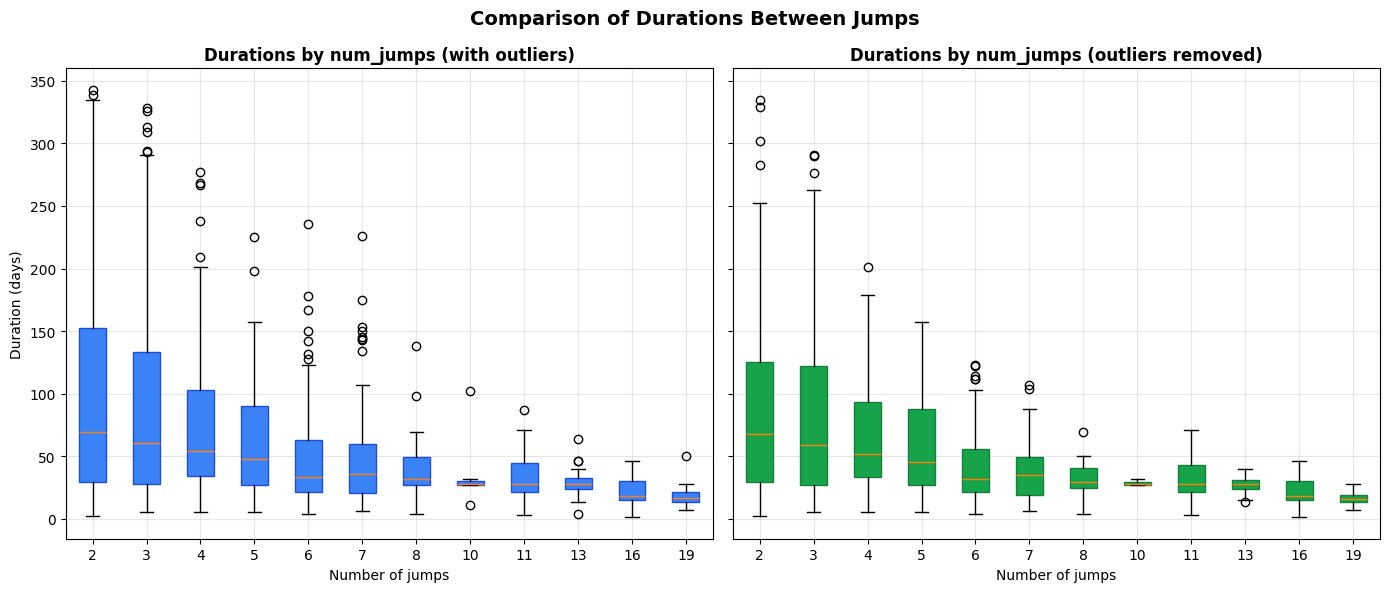

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Add durations column ---
def add_durations(row):
    jump_days = row['jump_days']
    if len(jump_days) > 1:
        durations = np.diff(jump_days)
    else:
        durations = np.array([])
    return durations

jump_info_unstable_situation['durations'] = jump_info_unstable_situation.apply(add_durations, axis=1)

# --- Step 2: Flatten durations for analysis ---
duration_expanded = (
    jump_info_unstable_situation
    .explode("durations")
    .dropna(subset=["durations"])
)
duration_expanded["durations"] = duration_expanded["durations"].astype(int)

# --- Step 3: Remove outliers by num_jumps group ---
def remove_outliers(series):
    data = series.dropna()
    if len(data) < 4:
        return data
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

duration_no_outliers = (
    duration_expanded.groupby("num_jumps")["durations"]
    .apply(remove_outliers)
    .reset_index(level=0)
)

# --- Step 4: Plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# Left: with outliers
axes[0].boxplot(
    [duration_expanded.loc[duration_expanded["num_jumps"]==n, "durations"]
     for n in sorted(duration_expanded["num_jumps"].unique())],
    labels=sorted(duration_expanded["num_jumps"].unique()),
    patch_artist=True,
    boxprops=dict(facecolor="#3b82f6", color="#1d4ed8")
)
axes[0].set_title("Durations by num_jumps (with outliers)", fontweight="bold")
axes[0].set_xlabel("Number of jumps")
axes[0].set_ylabel("Duration (days)")
axes[0].grid(alpha=0.3)

# Right: without outliers
axes[1].boxplot(
    [duration_no_outliers.loc[duration_no_outliers["num_jumps"]==n, "durations"]
     for n in sorted(duration_no_outliers["num_jumps"].unique())],
    labels=sorted(duration_no_outliers["num_jumps"].unique()),
    patch_artist=True,
    boxprops=dict(facecolor="#16a34a", color="#15803d")
)
axes[1].set_title("Durations by num_jumps (outliers removed)", fontweight="bold")
axes[1].set_xlabel("Number of jumps")
axes[1].grid(alpha=0.3)

plt.suptitle("Comparison of Durations Between Jumps", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


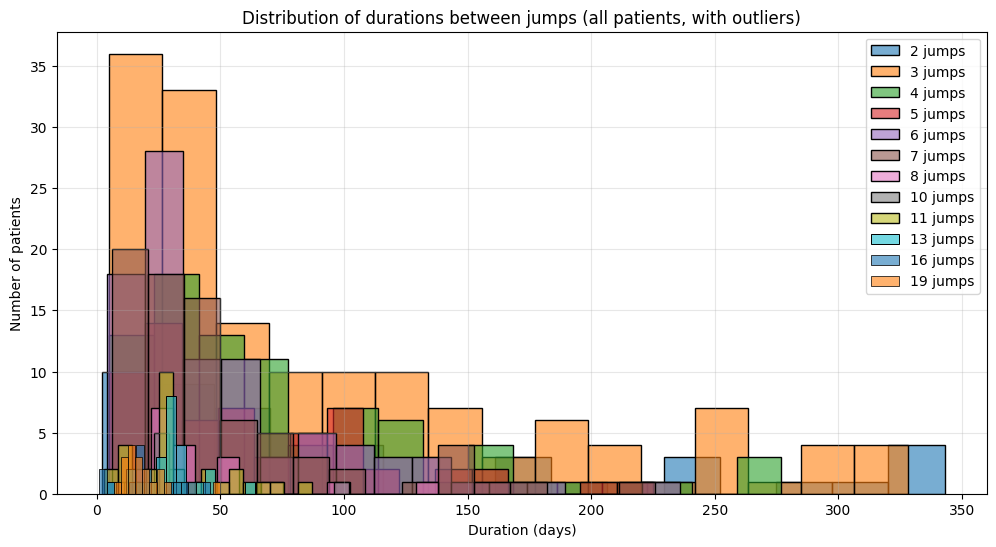

/tmp/ipython-input-852727356.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




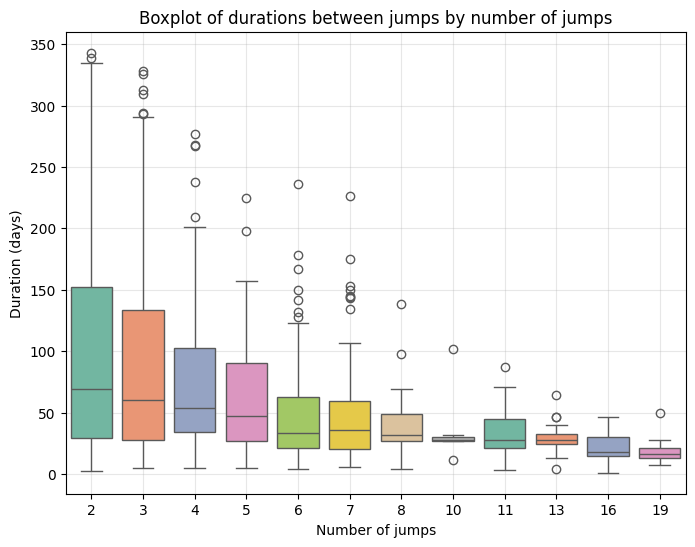

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Flatten durations ---
duration_expanded = (
    jump_info_unstable_situation
    .explode("durations")
    .dropna(subset=["durations"])
)
duration_expanded["durations"] = duration_expanded["durations"].astype(int)

# --- Step 2: Histogram per num_jumps ---
num_jump_groups = sorted(duration_expanded["num_jumps"].unique())

plt.figure(figsize=(12,6))
for n in num_jump_groups:
    sns.histplot(duration_expanded.loc[duration_expanded["num_jumps"]==n, "durations"],
                 label=f"{n} jumps", kde=False, bins=15, alpha=0.6)
plt.xlabel("Duration (days)")
plt.ylabel("Number of patients")
plt.title("Distribution of durations between jumps (all patients, with outliers)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Step 3: Boxplot per num_jumps ---
plt.figure(figsize=(8,6))
sns.boxplot(x="num_jumps", y="durations", data=duration_expanded,
            palette="Set2")
plt.xlabel("Number of jumps")
plt.ylabel("Duration (days)")
plt.title("Boxplot of durations between jumps by number of jumps")
plt.grid(alpha=0.3)
plt.show()


/tmp/ipython-input-3511622764.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




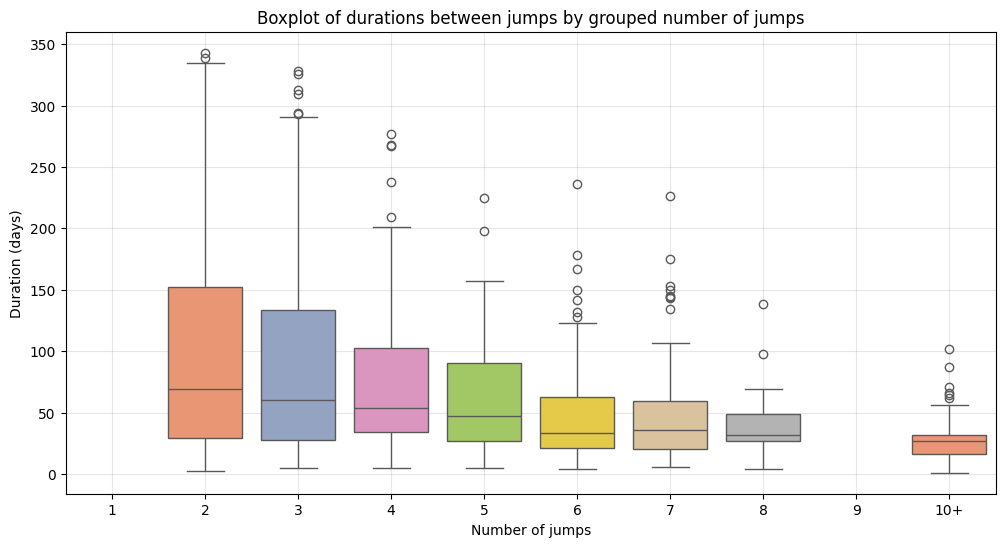

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Flatten durations ---
duration_expanded = (
    jump_info_unstable_situation
    .explode("durations")
    .dropna(subset=["durations"])
)
duration_expanded["durations"] = duration_expanded["durations"].astype(int)

# --- Step 1: Group num_jumps for labeling ---
def group_jumps(n):
    if n >= 10:
        return "10+"
    else:
        return str(n)

duration_expanded["jump_group"] = duration_expanded["num_jumps"].apply(group_jumps)

# --- Step 2: Sort labels properly ---
labels_order = [str(n) for n in range(1,10)] + ["10+"]

# --- Step 3: Boxplot ---
plt.figure(figsize=(12,6))
sns.boxplot(x="jump_group", y="durations", data=duration_expanded,
            order=labels_order, palette="Set2")
plt.xlabel("Number of jumps")
plt.ylabel("Duration (days)")
plt.title("Boxplot of durations between jumps by grouped number of jumps")
plt.grid(alpha=0.3)
plt.show()

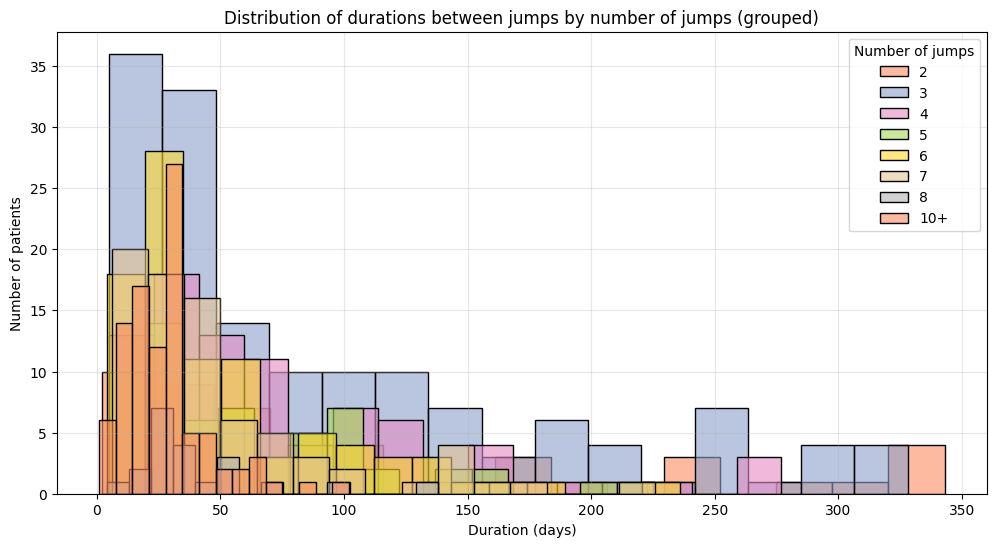

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Flatten durations ---
duration_expanded = (
    jump_info_unstable_situation
    .explode("durations")
    .dropna(subset=["durations"])
)
duration_expanded["durations"] = duration_expanded["durations"].astype(int)

# --- Group num_jumps (10+ together) ---
def group_jumps(n):
    if n >= 10:
        return "10+"
    else:
        return str(n)

duration_expanded["jump_group"] = duration_expanded["num_jumps"].apply(group_jumps)

# --- Histogram per group ---
plt.figure(figsize=(12,6))
labels_order = [str(n) for n in range(1,10)] + ["10+"]
colors = sns.color_palette("Set2", len(labels_order))

for i, group in enumerate(labels_order):
    group_data = duration_expanded.loc[duration_expanded["jump_group"]==group, "durations"]
    sns.histplot(group_data, bins=15, kde=False, alpha=0.6, color=colors[i], label=group)

plt.xlabel("Duration (days)")
plt.ylabel("Number of patients")
plt.title("Distribution of durations between jumps by number of jumps (grouped)")
plt.legend(title="Number of jumps")
plt.grid(alpha=0.3)
plt.show()
